# AI-Generated Image Detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import seaborn as sns

import pathlib
from zipfile import ZipFile
import imagehash
import random

### 1.   Importing the Data

- Since the data is in a zip file, It needs to be unzipped to access the images

In [2]:
# Unzip folder
zip_object = ZipFile('datasets/dataset2.zip', 'r')
zip_object.extractall()

-   The data come by default with a training and testing already established

In [3]:
# Storing image data into variables
train_dir = pathlib.Path('train/').with_suffix('')
test_dir = pathlib.Path('test/').with_suffix('')

In [4]:
train_img_array, test_img_array = list(train_dir.glob('*/*')), list(test_dir.glob('*/*'))
total_dataset = train_img_array + test_img_array

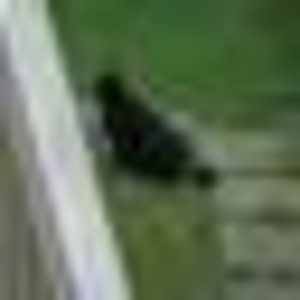

In [5]:
# Display random image in the dataset
random_number = random.randint(0, len(train_img_array))
Image.open(str(train_img_array[random_number])).resize((300, 300))

#### Information about the dataset

In [6]:
# Check the number of items in the dataset
print(f"Training image count : {len(train_img_array)} \nTesting image count : {len(test_img_array)} \nTotal data : {len(total_dataset)}")

Training image count : 100000 
Testing image count : 20000 
Total data : 120000


In [7]:
# Check the number of type image extension in the dataset
image_types = [
    {"file_type": "jpeg", "count": 0},
    {"file_type": "png", "count": 0},
    {"file_type": "jpg", "count": 0},
    {"file_type": "other", "count": 0},
]

# train_image_types = [
#     {"file_type": "jpeg", "count": 0},
#     {"file_type": "png", "count": 0},
#     {"file_type": "jpg", "count": 0},
#     {"file_type": "other", "count": 0},
# ]

# test_image_types = [
#     {"file_type": "jpeg", "count": 0},
#     {"file_type": "png", "count": 0},
#     {"file_type": "jpg", "count": 0},
#     {"file_type": "other", "count": 0},
# ]

def count_filetype(dataset, type_array):
    type_count = len(type_array)
    for c, file_name in enumerate(dataset):
        # Split the file name by the period (.) character
        parts = str(file_name).split(".")
        file_extension = str(parts[-1]).lower() # Get the extension type.
        # print("outer loop : ", c)
        for counter in range(type_count):
            # print("inner loop : ", counter)
            if file_extension == type_array[counter]["file_type"]:
                type_array[counter]["count"]+=1
                break
            if counter == (type_count - 1): # If the loop falls in the "other category"
                type_array[-1]["count"]+=1


# Counts image types occurrence for dataset 
count_filetype(total_dataset, image_types)

# Counts image types occurrence for training set 
# count_filetype(train_img_array, train_image_types)

# Counts image types occurrence for testing set 
# count_filetype(test_img_array, test_image_types)


# Display result for train dataset
for image_type in image_types:
  print(f"Number of {image_type['file_type']} images inside the dataset : {image_type['count']}")
  
# # Display result for train dataset
# for image_type in train_image_types:
#   print(f"Number of {image_type['file_type']} images inside the training dataset : {image_type['count']}")

# print("----------------------------------------------")
# Display result for test dataset
# for image_type in test_image_types:
#   print(f"Number of {image_type['file_type']} images inside the testing dataset : {image_type['count']}")

Number of jpeg images inside the dataset : 0
Number of png images inside the dataset : 0
Number of jpg images inside the dataset : 120000
Number of other images inside the dataset : 0


- We can observe that the dataset only contains jpg images in both the training and testing dataset

### 2.  Data cleaning

#### Check if the dataset contains corrupted and duplicated images.

In [8]:
def clean_image_data(dataset: list):
    # cleaned_images = []
    cleaned_images = 0
    # corrupted_images = []
    corrupted_images = 0
    imgs_shape = []  
    hash_dict = {}
    # duplicate_images = []  
    duplicate_images = 0  
    temp_dataset: list[bool] = [] 

    for count, filename in enumerate(dataset):
        filename = str(filename)
        try:
            with Image.open(filename) as img:
                # Optionally, perform additional checks such as size, format, etc.
                # Check image size
                # if img.size < min_size:
                #     print(f"Ignoring small image: {filename}")
                #     continue
                
                # print("image size : ", img.size)
                
                # img_width.append(img.size[0])
                # img_height.append(img.size[1])
                # Calculate the hash of the image
                img_hash = imagehash.average_hash(img)

                # Check if the hash already exists in the dictionary
                if img_hash in hash_dict:
                    duplicate_images+=1
                    temp_dataset.append(True)
                    # duplicate_images.append([filename, True])
                else:
                    hash_dict[img_hash] = filename
                    temp_dataset.append(False)
                    
                imgs_shape.append(img.size)
                cleaned_images+=1
                # cleaned_images.append(filename)
        except Exception as e:
            # Handle corrupted or unreadable images
            # corrupted_images.append(filename)
            corrupted_images+=1
            print(f"Corrupted image: {filename}, Error: {e}")

    return cleaned_images, corrupted_images, duplicate_images, temp_dataset, imgs_shape
# , img_width, img_height

# data_directory = train_img_array
cleaned_images, corrupted_images, duplicate_images, duplicates_values, imgs_shape = clean_image_data(total_dataset)
# , img_width, img_height = clean_image_data(total_dataset)

print(f"Cleaned images: {cleaned_images}")
print(f"Corrupted images: {corrupted_images}")
print("duplicate images : ", duplicate_images )
print("temp : ", len(duplicates_values) )
# print("duplicate images : ", hash_dict )

Cleaned images: 120000
Corrupted images: 0
duplicate images :  3342
temp :  120000


- We observe that the dataset does not contain any corrupted image
- However duplicates images are in the dataset.

- Duplicated images are based on the image content rather than filenames. 
- The process to find duplicated images is as follows:
    - Turn the image content into a hash value and get the average value of the hash.
    - Compare images hash value and determine if there are duplicate or near-duplicate images based on similarity thresholds.

In [9]:
# Transforming the dataset list into a pandas.Series Dataframe 
df = pd.DataFrame(total_dataset, columns=["Filename"])
shapes = pd.DataFrame(imgs_shape, columns=["width", "height"])
dupl = pd.DataFrame(duplicates_values, columns=["duplicated"])

df = df.merge(shapes, left_index=True, right_index=True)

# merge_df = df.merge(dupl, left_index=True, right_index=True)

In [10]:
# Remove duplicates
print("Before Duplicates :", len(df))

df = df[~dupl["duplicated"]]

print("After removing duplicates :", len(df))

Before Duplicates : 120000
After removing duplicates : 116658


In [11]:
# reset index num 
df.reset_index(drop=True)

,Filename,width,height
0,train/REAL/4053 (9).jpg,32,32
1,train/REAL/2864 (4).jpg,32,32
2,train/REAL/3536 (3).jpg,32,32
3,train/REAL/0183 (8).jpg,32,32
4,train/REAL/1607 (8).jpg,32,32
...,...,...,...
116653,test/FAKE/357 (8).jpg,32,32
116654,test/FAKE/612.jpg,32,32
116655,test/FAKE/603 (9).jpg,32,32
116656,test/FAKE/282.jpg,32,32


In [12]:
# creating new columns to tag data inside the dataset
df["folder_type"] = df["Filename"].apply(lambda x: "Test" if str(x).split("/")[0] == "test" else "Train") 
df["tag"] = df["Filename"].apply(lambda x: "REAL" if str(x).split("/")[1] == "REAL" else "FAKE") 

In [13]:
df.head()

,Filename,width,height,folder_type,tag
0,train/REAL/4053 (9).jpg,32,32,Train,REAL
1,train/REAL/2864 (4).jpg,32,32,Train,REAL
2,train/REAL/3536 (3).jpg,32,32,Train,REAL
3,train/REAL/0183 (8).jpg,32,32,Train,REAL
4,train/REAL/1607 (8).jpg,32,32,Train,REAL


### 3.  Data exploration

In [14]:
# Displays metrics about numerical data
df.describe()

,width,height
count,116658.0,116658.0
mean,32.0,32.0
std,0.0,0.0
min,32.0,32.0
25%,32.0,32.0
50%,32.0,32.0
75%,32.0,32.0
max,32.0,32.0


In [15]:
df.shape

(116658, 5)

In [16]:
df.apply(pd.Series.unique)

Filename       [train/REAL/4053 (9).jpg, train/REAL/2864 (4)....
width                                                       [32]
height                                                      [32]
folder_type                                        [Train, Test]
tag                                                 [REAL, FAKE]
dtype: object

- From this data we observe that all the images in the dataset are set in 32x32 pixels

In [17]:
# Displays metrics about non-numerical data
df.describe(include=['object'])

,Filename,folder_type,tag
count,116658,116658,116658
unique,116658,2,2
top,train/REAL/4053 (9).jpg,Train,REAL
freq,1,97536,59123


In [18]:
# Get the number of "REAL" and "FAKE" tags
num_real_tags = df["tag"].apply(lambda x: x.count("REAL")).sum()
num_fake_tags = df["tag"].apply(lambda x: x.count("FAKE")).sum()

num_train_real = df[df["folder_type"] == "Train"]["tag"].apply(lambda x: x.count("REAL")).sum()
num_train_fake = df[df["folder_type"] == "Train"]["tag"].apply(lambda x: x.count("FAKE")).sum()

num_test_real = df[df["folder_type"] == "Test"]["tag"].apply(lambda x: x.count("REAL")).sum()
num_test_fake = df[df["folder_type"] == "Test"]["tag"].apply(lambda x: x.count("FAKE")).sum()

# Get the number of "Train" and "Test" type
num_train = df["folder_type"].apply(lambda x: x.count("Train")).sum()
num_test = df["folder_type"].apply(lambda x: x.count("Test")).sum()

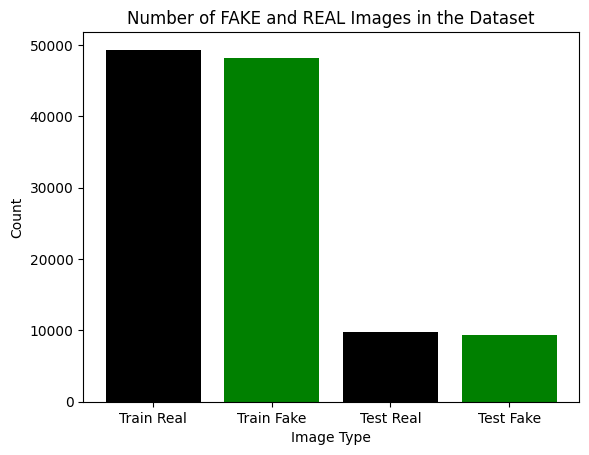

Number of 'FAKE' images: 57535
Number of 'REAL' images: 59123
Difference: 1588


In [19]:
# Create a bar chart
plt.bar(['Train Real', 'Train Fake', "Test Real", "Test Fake"], [num_train_real, num_train_fake, num_test_real, num_test_fake], color=["black", "green"])
plt.xlabel('Image Type')
plt.ylabel('Count')
plt.title('Number of FAKE and REAL Images in the Dataset')
# colors = {'Train Real': ['black', 'green', 'blue']}
# labels = list(colors.keys())
# handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# plt.legend(handles, labels)
plt.show()
print("Number of 'FAKE' images:", num_fake_tags)
print("Number of 'REAL' images:", num_real_tags)
print("Difference:", num_real_tags - num_fake_tags)

-   from this chart it is noticeable that the difference between REAL and FAKE images is not much

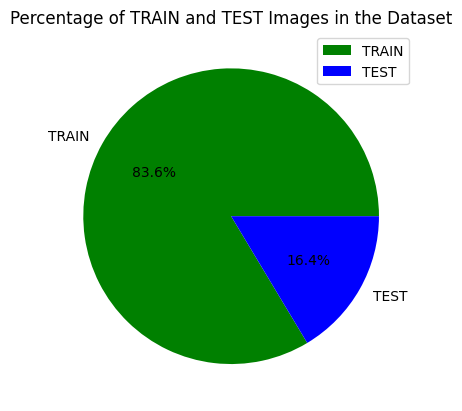

Number of 'Train' images: 97536
Number of 'Test' images: 19122


In [20]:
# Create a piechart

plt.pie([num_train, num_test], labels=["TRAIN", "TEST"], colors=["green", "blue"], autopct='%1.1f%%')
plt.title('Percentage of TRAIN and TEST Images in the Dataset')
plt.legend()
plt.show()
print("Number of 'Train' images:", num_train)
print("Number of 'Test' images:", num_test)

#### Next steps :
-   Investigate if it is needed to handle noisy data in the dataset

### 3. Data preprocessing

In [21]:
df.head()

,Filename,width,height,folder_type,tag
0,train/REAL/4053 (9).jpg,32,32,Train,REAL
1,train/REAL/2864 (4).jpg,32,32,Train,REAL
2,train/REAL/3536 (3).jpg,32,32,Train,REAL
3,train/REAL/0183 (8).jpg,32,32,Train,REAL
4,train/REAL/1607 (8).jpg,32,32,Train,REAL


In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

2024-03-23 23:52:01.975729: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 23:52:01.975750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 23:52:01.976413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-23 23:52:01.980147: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 23:52:02.636914: W tensorflow/compiler/tf2

In [23]:
# Function preprocess image
def preprocess_image(image_path, target_size=(32, 32)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image

def extract_features(model, images):
    features = []
    for image in images:
        features.append(model.predict(image[np.newaxis, ...])[0])
    return np.array(features)

In [24]:
image_paths = df["Filename"].copy().astype(str).tolist()
labels = df["tag"].copy().astype(str).tolist()

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Map preprocessing function to the datasets
train_dataset = train_dataset.map(lambda x, y: (preprocess_image(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocess_image(x), y))

# Optionally, shuffle and batch the datasets
BATCH_SIZE = 34
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


2024-03-23 23:52:03.278722: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 23:52:03.296377: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 23:52:03.296542: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [25]:
# Iterate over the dataset (for demonstration)
for batch_images, batch_labels in train_dataset.take(1):
    print("Batch images shape:", batch_images.shape)
    print("Batch labels:", batch_labels.numpy())

Batch images shape: (34, 32, 32, 3)
Batch labels: [b'FAKE' b'REAL' b'FAKE' b'REAL' b'REAL' b'REAL' b'FAKE' b'FAKE' b'REAL'
 b'REAL' b'FAKE' b'REAL' b'REAL' b'REAL' b'REAL' b'FAKE' b'REAL' b'REAL'
 b'FAKE' b'FAKE' b'REAL' b'REAL' b'FAKE' b'REAL' b'REAL' b'REAL' b'REAL'
 b'FAKE' b'FAKE' b'FAKE' b'REAL' b'FAKE' b'REAL' b'REAL']


To do :
- Show a Visual representation of the preprocessed data

In [26]:
# # Map preprocessing function to the datasets
# train_dataset = train_dataset.map(lambda x, y: (preprocess_image(x), y))
# test_dataset = test_dataset.map(lambda x, y: (preprocess_image(x), y))

# Load pre-trained CNN model
base_model = tf.keras.applications.MobileNetV2(input_shape=(32, 32, 3),
                                               include_top=False,
                                               weights='imagenet')

# Extract features using the pre-trained model
X_train = []
train_labels_list = []
for batch_images, batch_labels in train_dataset:
    features = base_model.predict(batch_images)
    # Reshape features to 2D
    features = np.reshape(features, (features.shape[0], -1))
    X_train.extend(features)
    train_labels_list.extend(batch_labels.numpy())

X_test = []
test_labels_list = []
for batch_images, batch_labels in test_dataset:
    features = base_model.predict(batch_images)
    # Reshape features to 2D
    features = np.reshape(features, (features.shape[0], -1))
    X_test.extend(features)
    test_labels_list.extend(batch_labels.numpy())

# Convert lists to arrays
X_train = np.array(X_train)
Y_train = np.array(train_labels_list)
X_test = np.array(X_test)
Y_test = np.array(test_labels_list)

2024-03-23 23:52:06.116328: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-23 23:52:06.176098: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 71ms/step


In [27]:
X_train.shape

(93326, 1280)

In [28]:
X_test.shape

(23332, 1280)

In [29]:
# Using PCA to reduce the features dimensions for the reshaped training set
pca = PCA(n_components=128)
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

pca_train.shape

(93326, 128)

In [30]:
# Reconstructing the images using pca inverse
X_reconstruct = pca.inverse_transform(pca_train)

#Recontructed training set dims
X_reconstruct.shape

(93326, 1280)

In [31]:
index = np.random.randint(X_reconstruct.shape[0])
X_train[index]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [32]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
X_reconstruct[0]

array([-8.0278426e-08, -9.6583521e-05,  6.4641227e-08, ...,
        0.0000000e+00,  0.0000000e+00, -2.4231596e-05], dtype=float32)

In [34]:
for batch_images in X_reconstruct:
    print(batch_images[0])
    # Visualizing a sample reconstructed image
    # plt.figure(figsize=(10,5))
    # index = np.random.randint(batch_images.shape[0])
    # plt.subplot(121)
    # plt.title("Original Image")
    # plt.imshow(batch_images[index])
    # plt.axis('off')
    # plt.subplot(122)
    # plt.title("Reconstructed Image")
    # plt.imshow((np.reshape(batch_images[index],(100, 100,3))))
    # plt.axis('off')
    # plt.show()
# X_reconstruct

-8.0278426e-08
1.2042341e-07
6.875557e-09
7.067844e-09
-3.713362e-08
-1.7284218e-07
3.5576445e-08
3.6234344e-08
-6.2797554e-08
-2.5842745e-08
1.0663856e-07
9.5203276e-08
9.565318e-09
2.8546125e-08
2.9055233e-08
-5.819804e-08
1.9193067e-08
1.9846766e-08
2.0734568e-08
7.082259e-08
8.558266e-08
-9.086981e-08
8.382164e-08
-5.7502547e-08
-6.589931e-08
7.836495e-08
1.6301858e-08
2.0255271e-08
-5.0249156e-08
2.0120685e-09
5.0264584e-09
-7.3431025e-08
1.6177465e-08
5.3515713e-08
3.4506613e-08
-8.968317e-09
6.532227e-08
-1.1119241e-08
-8.728962e-08
-5.057615e-08
6.7091763e-09
-1.069479e-08
5.986858e-08
-2.5282336e-08
-2.8098682e-08
-3.4059536e-08
1.7575255e-08
-2.6412062e-08
-2.4375867e-08
-9.140015e-08
1.7351734e-08
-6.734214e-09
8.474386e-08
-1.9712783e-08
-1.0647323e-07
1.19319745e-08
1.94548e-08
1.5810977e-08
6.789409e-08
-5.2213874e-08
7.256359e-09
-5.8242165e-08
1.6177466e-08
-4.2939547e-08
-6.586089e-08
5.816976e-08
3.8279747e-08
1.7246562e-08
1.2760725e-08
1.617746e-08
-3.2996187e-08
-4

In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(Y_train)
y_test = le.fit_transform(Y_test)
le.classes_

array([b'FAKE', b'REAL'], dtype='|S4')

In [42]:
models = {}

#models with default parameter
models['KNN'] = KNeighborsClassifier()
models['SGD'] = SGDClassifier()
models['SVM'] = SVC(gamma='auto')
# models['VC'] = VotingClassifier()

In [37]:
# Initialize and train KNN classifier
knn = KNeighborsClassifier()  # You can adjust the number of neighbors
knn.fit(pca_train, y_train)

# Evaluate the model
predictions = knn.predict(pca_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.6311503514486542


In [43]:
# use crossvalidate to on all the models to get the accuracy and f1-score
for name, model in models.items():
    scores = cross_validate(model, pca_train, y_train, cv=5, scoring=['accuracy', 'f1'], return_train_score=True)
    print("Accuracy:" , 'train:', scores['train_accuracy'].mean(), '| test:', scores['test_accuracy'].mean())
    print("F1-score:" , 'train:', scores['train_f1'].mean(), '| test: ',
    scores['test_f1'].mean())
    print("-----------------------------------------------------------")

Accuracy: train: 0.737291850278537 | test: 0.6214131479400067
F1-score: train: 0.7291609661531446 | test:  0.6081568809639298
-----------------------------------------------------------
Accuracy: train: 0.6419566999494559 | test: 0.6385251053750178
F1-score: train: 0.5958282609464355 | test:  0.5923448708833947
-----------------------------------------------------------


KeyboardInterrupt: 